In [1]:
import xarray as xr
import rioxarray as rio
import geopandas as gpd
import os
import numpy as np

In [2]:
from IPython.display import Image
from IPython.core.display import HTML
import matplotlib.pyplot as plt
from matplotlib import cm, colors
%matplotlib inline

# Load python library

In [3]:
import geomed3d

# Parameters

In [4]:
# projected coordinates system
epsg = 32635

# processing resolution, depth, range filter, meter

# regional model
resolution = 4*1000
DEPTH=300*1000
SIGMA1=40*1000
SIGMA2=60*1000

# constant value or file name
DEM='/Users/mbg/Documents/geo-data/GEBCO_2020/GEBCO_2020.nc'
# see the recent version at https://topex.ucsd.edu/pub/global_grav_1min/
RASTER='/Users/mbg/Documents/geo-data/Sandwell-Smith/grav_29.1.nc'
AREA = '../data/ref/AOI.area_greece.32635.slice.geojson'

# postprocessing
q = {
    'density':     [0.5,99.5],
    'halteration': [2,98],
    'valteration': [2,98],
    'hanomaly':    [2,98],
    'vanomaly':    [2,98]
}

# Load work area

POLYGON ((1248890.375 3433841, 1248890.375 4221841, 88890.390625 4221841, 88890.390625 3433841, 1248890.375 3433841))


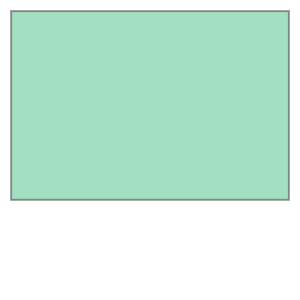

In [5]:
area = gpd.read_file(AREA)
print(area.geometry[0])
area.geometry[0]

# Prepare and load raster (with processing buffer)

In [6]:
# add buffer for raster processing
buffer = DEPTH*np.sqrt(2)+4*SIGMA2
print ('buffer', buffer)

buffer 664264.0687119286


In [7]:
(minx, miny, maxx, maxy) = area.geometry[0].buffer(buffer).bounds
(minx, miny, maxx, maxy)

(-575373.6780869286, 2769576.9312880714, 1913154.4437119286, 4886105.068711929)

In [8]:
!ls -lh {RASTER}

-rw-r--r--@ 1 mbg  staff   602M May 19  2020 /Users/mbg/Documents/geo-data/Sandwell-Smith/grav_29.1.nc


In [9]:
!mkdir -p ../data/raw/

In [10]:
basename = os.path.splitext(os.path.split(RASTER)[1])[0]
!gdalwarp -overwrite -s_srs WGS84 -t_srs EPSG:{epsg} -r bilinear -tr {resolution} {resolution} \
    -te {minx} {miny} {maxx} {maxy} \
    {RASTER} \
    ../data/raw/{basename}.{epsg}.{resolution}m.tif

Creating output file that is 622P x 529L.
Processing /Users/mbg/Documents/geo-data/Sandwell-Smith/grav_29.1.nc [1/1] : 0Using internal nodata values (e.g. nan) for image /Users/mbg/Documents/geo-data/Sandwell-Smith/grav_29.1.nc.
Copying nodata values from source /Users/mbg/Documents/geo-data/Sandwell-Smith/grav_29.1.nc to destination ../data/raw/grav_29.1.32635.4000m.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


In [11]:
raster0 = rio.open_rasterio(f'../data/raw/{basename}.{epsg}.{resolution}m.tif').squeeze().rename('grav')
raster0

<xarray.DataArray 'grav' (y: 529, x: 622)>
[329038 values with dtype=float32]
Coordinates:
    band         int64 1
  * x            (x) float64 -5.734e+05 -5.694e+05 ... 1.907e+06 1.911e+06
  * y            (y) float64 4.884e+06 4.88e+06 ... 2.776e+06 2.772e+06
    spatial_ref  int64 0
Attributes: (12/16)
    AREA_OR_POINT:     Area
    lat#actual_range:  [-80.  80.]
    lat#long_name:     latitude
    lat#units:         degrees_north
    lon#actual_range:  [-180.  180.]
    lon#long_name:     longitude
    ...                ...
    node_offset:       1
    actual_range:      [-389.27554321  942.61932373]
    long_name:         z
    _FillValue:        nan
    scale_factor:      1.0
    add_offset:        0.0

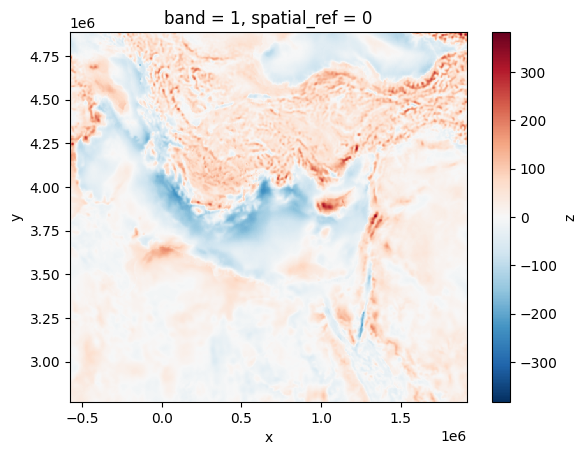

In [12]:
raster0.plot()

# Prepare and load dem

In [13]:
(minx, miny, maxx, maxy) = area.geometry[0].bounds
(minx, miny, maxx, maxy)

(88890.390625, 3433841.0, 1248890.375, 4221841.0)

In [14]:
!ls -lh {DEM}

-rw-r--r--  1 mbg  staff   7.0G Apr 28  2020 /Users/mbg/Documents/geo-data/GEBCO_2020/GEBCO_2020.nc


In [15]:
if isinstance(DEM,str):
    basename = os.path.splitext(os.path.split(DEM)[1])[0]
    !gdalwarp -overwrite -s_srs WGS84 -t_srs EPSG:{epsg} -r bilinear -tr {resolution} {resolution} \
        -te {minx} {miny} {maxx} {maxy} \
        {DEM} \
        ../data/raw/{basename}.{epsg}.{resolution}m.tif

Creating output file that is 290P x 197L.
Processing /Users/mbg/Documents/geo-data/GEBCO_2020/GEBCO_2020.nc [1/1] : 0Using internal nodata values (e.g. -32767) for image /Users/mbg/Documents/geo-data/GEBCO_2020/GEBCO_2020.nc.
Copying nodata values from source /Users/mbg/Documents/geo-data/GEBCO_2020/GEBCO_2020.nc to destination ../data/raw/GEBCO_2020.32635.4000m.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


In [16]:
if isinstance(DEM,str):
    grid = rio.open_rasterio(f'../data/raw/{basename}.{epsg}.{resolution}m.tif').squeeze()
elif DEM is None or isinstance(DEM,int) or isinstance(DEM,float):
    grid = (DEM if DEM is not None else 0) + xr.zeros_like(raster0.sel(x=slice(minx,maxx),y=slice(maxy,miny)))
grid

<xarray.DataArray 'elevation' (y: 197, x: 290)>
[57130 values with dtype=int16]
Coordinates:
    band         int64 1
  * x            (x) float64 9.089e+04 9.489e+04 ... 1.243e+06 1.247e+06
  * y            (y) float64 4.22e+06 4.216e+06 4.212e+06 ... 3.44e+06 3.436e+06
    spatial_ref  int64 0
Attributes: (12/35)
    AREA_OR_POINT:           Area
    lat#axis:                Y
    lat#long_name:           latitude
    lat#sdn_parameter_name:  Latitude north
    lat#sdn_parameter_urn:   SDN:P01::ALATZZ01
    lat#sdn_uom_name:        Degrees north
    ...                      ...
    sdn_uom_urn:             SDN:P06::ULAA
    standard_name:           height_above_reference_ellipsoid
    units:                   m
    _FillValue:              -32767
    scale_factor:            1.0
    add_offset:              0.0

In [17]:
df_grid = grid.to_dataframe('z').reset_index()
df_grid

,y,x,band,spatial_ref,z
0,4219841.0,9.089039e+04,1,0,1070
1,4219841.0,9.489039e+04,1,0,1268
2,4219841.0,9.889039e+04,1,0,1272
3,4219841.0,1.028904e+05,1,0,881
4,4219841.0,1.068904e+05,1,0,625
...,...,...,...,...,...
57125,3435841.0,1.230890e+06,1,0,399
57126,3435841.0,1.234890e+06,1,0,464
57127,3435841.0,1.238890e+06,1,0,537
57128,3435841.0,1.242890e+06,1,0,523


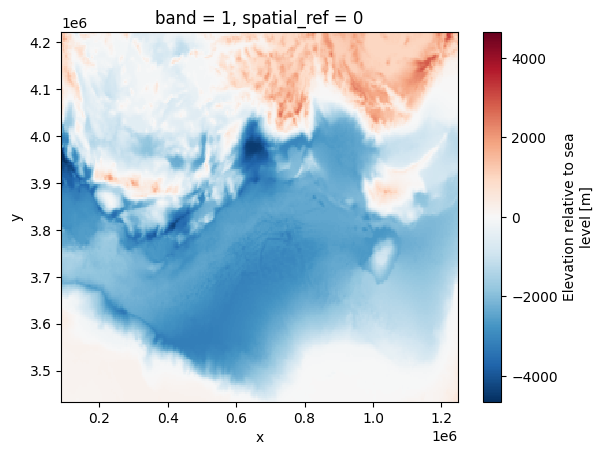

In [18]:
grid.plot()

# Pre-processing raster

In [19]:
raster = geomed3d.geomed3d.gaussian_range(raster0, SIGMA1/resolution, SIGMA2/resolution)

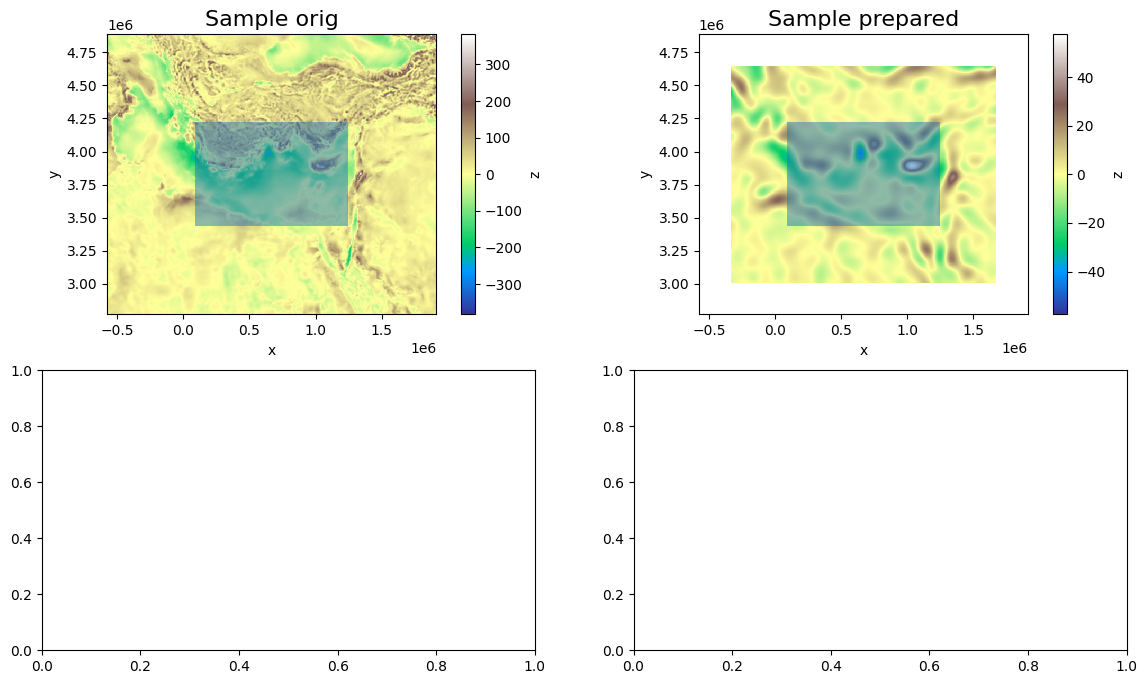

In [20]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(14, 8))

raster0.plot(ax=ax1, cmap='terrain')
area.plot(ax=ax1, alpha=0.5)
ax1.set_title('Sample orig',fontsize=16)

raster.plot(ax=ax2, cmap='terrain')
area.plot(ax=ax2, alpha=0.5)
#area.buffer(1000).plot(ax=ax2, alpha=0.5)

ax2.set_title('Sample prepared',fontsize=16)

#hist, bin_edges = np.histogram(raster0, bins=1000, density=True)
#ax3.plot(bin_edges[1:],hist)
#ax3.set_title('Histogram orig',fontsize=16)

#hist, bin_edges = np.histogram(raster, bins=1000, density=True,
#                              range=(np.nanmin(raster.values),np.nanmax(raster.values)))
#ax4.plot(bin_edges[1:],hist)
#ax4.set_title('Histogram prepared',fontsize=16)

fig.subplots_adjust(hspace=0.2)
plt.show()

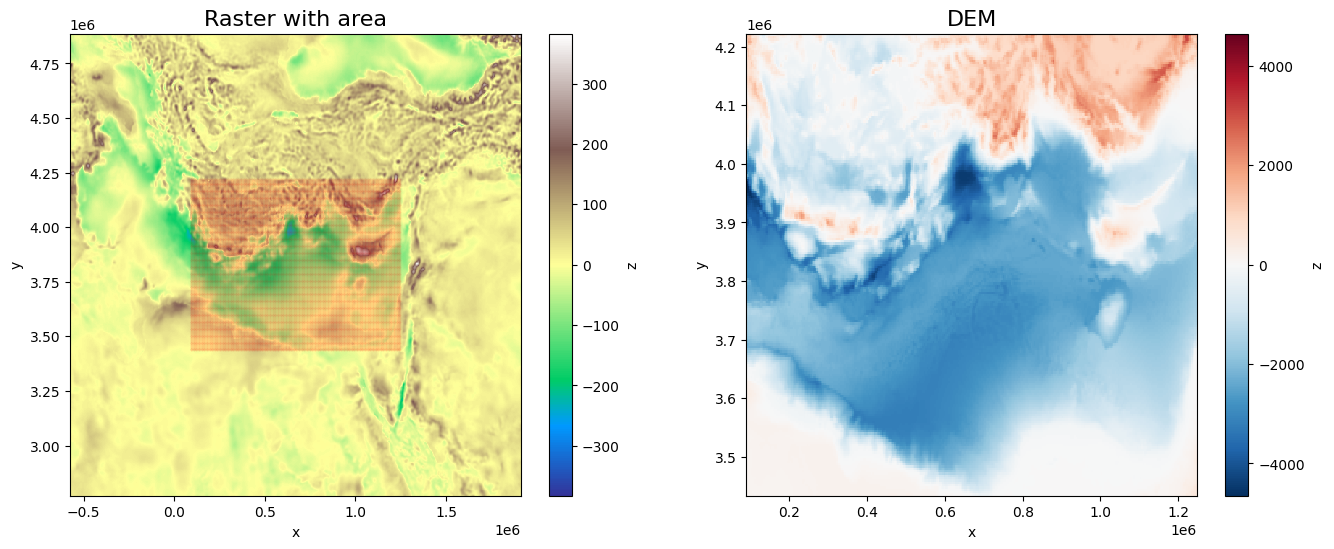

In [21]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 6))

raster0.plot(cmap='terrain', ax=ax1)
ax1.scatter(df_grid.x,df_grid.y, s=0.0005, c='red')
#area.plot(ax=ax1, alpha=0.5)
ax1.set_title('Raster with area',fontsize=16)

xr.Dataset.from_dataframe(df_grid.set_index(['y','x'])[['z']]).z.plot(ax=ax2)
ax2.set_title('DEM',fontsize=16)

fig.subplots_adjust(hspace=0.15)
plt.show()

# 3D volume

In [22]:
%%time

radius = int(round(DEPTH/(resolution*0.707),0))
print ('radius', radius)
ds3d = geomed3d.geomed3d.compute(raster, df_grid, r=radius)
ds3d

radius 106
CPU times: user 11.3 s, sys: 329 ms, total: 11.6 s
Wall time: 11.6 s


<xarray.Dataset>
Dimensions:      (y: 197, x: 290, z: 106)
Coordinates:
  * y            (y) float64 3.436e+06 3.44e+06 3.444e+06 ... 4.216e+06 4.22e+06
  * x            (x) float64 9.089e+04 9.489e+04 ... 1.243e+06 1.247e+06
  * z            (z) float64 0.0 -2.828e+03 -5.657e+03 ... -2.942e+05 -2.97e+05
Data variables:
    density      (z, y, x) float32 nan nan nan nan ... 1.967 1.962 2.367 2.413
    halteration  (z, y, x) float32 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    valteration  (z, y, x) float32 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    hanomaly     (z, y, x) float32 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    vanomaly     (z, y, x) float32 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0

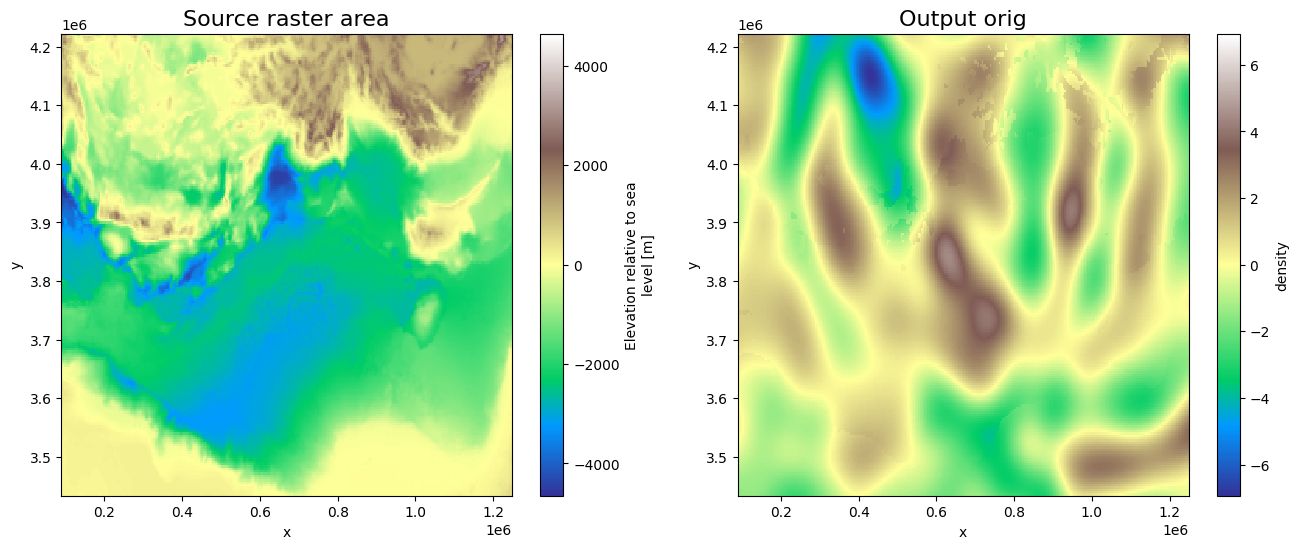

In [23]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 6))

grid.plot(cmap='terrain', ax=ax1)
ax1.set_title('Source raster area',fontsize=16)

ds3d.density.isel(z=-1).plot(cmap='terrain', ax=ax2)
ax2.set_title('Output orig',fontsize=16)

fig.subplots_adjust(hspace=0.15)
plt.show()

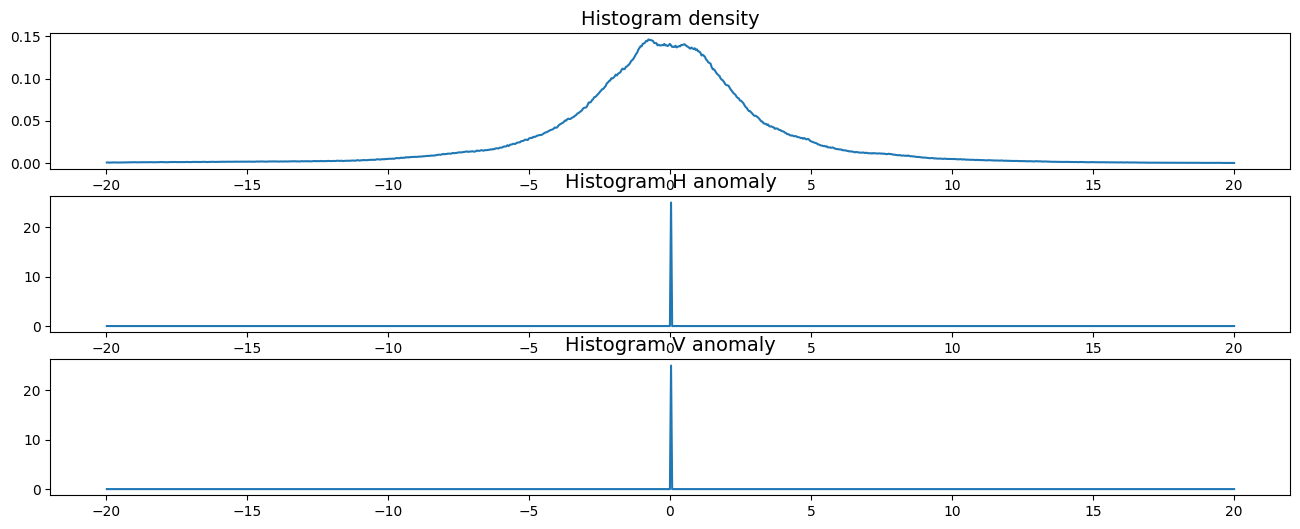

In [24]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(16, 6))

hist, bin_edges = np.histogram(ds3d.density, bins=1000, density=True,
                              range=(-20,20))
ax1.plot(bin_edges[1:],hist)
ax1.set_title('Histogram density', fontsize=14)

hist, bin_edges = np.histogram(ds3d.hanomaly, bins=1000, density=True,
                              range=(-20,20))
ax2.plot(bin_edges[1:],hist)
ax2.set_title('Histogram H anomaly', fontsize=14)

hist, bin_edges = np.histogram(ds3d.vanomaly, bins=1000, density=True,
                              range=(-20,20))
ax3.plot(bin_edges[1:],hist)
ax3.set_title('Histogram V anomaly', fontsize=14)

plt.show()

## Analyze and output the data

In [25]:
basename = os.path.splitext(os.path.split(RASTER)[1])[0]
basename

'grav_29.1'

crop hist density -19.17164813041687 16.489754362106268
crop hist halteration 0.0 0.0
crop hist valteration 0.0 0.0


/Users/mbg/Documents/github-public/geomed3d/geomed3d/vtk.py:55: RuntimeWarning: invalid value encountered in divide
  vals = 100.*(da.values - np.nanmin(da.values))/(np.nanmax(da.values)-np.nanmin(da.values))
/Users/mbg/Documents/github-public/geomed3d/geomed3d/vtk.py:55: RuntimeWarning: invalid value encountered in divide
  vals = 100.*(da.values - np.nanmin(da.values))/(np.nanmax(da.values)-np.nanmin(da.values))
/Users/mbg/Documents/github-public/geomed3d/geomed3d/vtk.py:55: RuntimeWarning: invalid value encountered in divide
  vals = 100.*(da.values - np.nanmin(da.values))/(np.nanmax(da.values)-np.nanmin(da.values))


crop hist hanomaly 0.0 0.0
crop hist vanomaly 0.0 0.0


/Users/mbg/Documents/github-public/geomed3d/geomed3d/vtk.py:55: RuntimeWarning: invalid value encountered in divide
  vals = 100.*(da.values - np.nanmin(da.values))/(np.nanmax(da.values)-np.nanmin(da.values))


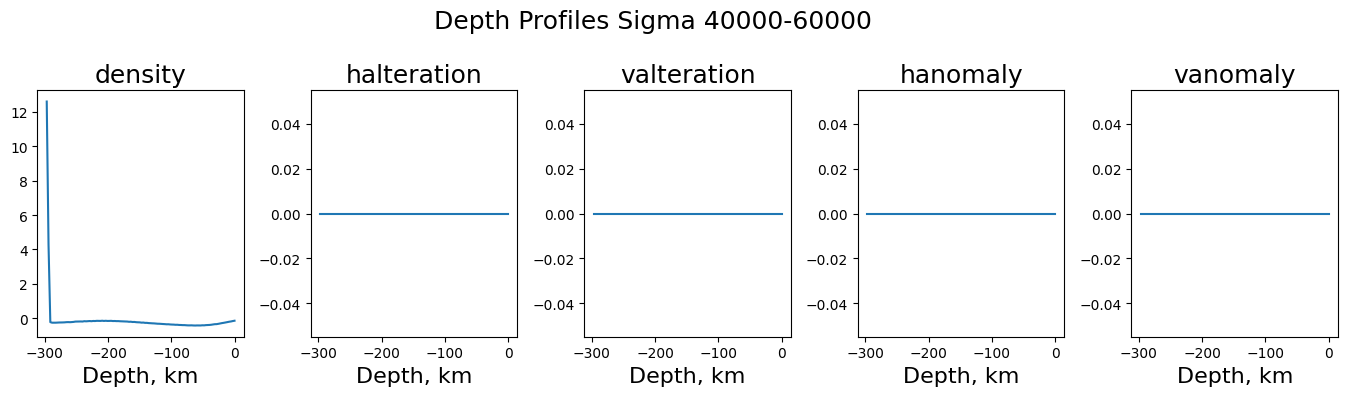

In [26]:
fig = plt.figure(figsize=(14,4))
for idx,stat in enumerate(ds3d.data_vars):
    #print (idx,stat)
    da = ds3d[stat].copy()
    # reverse z axis
    da = da.reindex(z=da.z[::-1])
    # crop histogramm
    pcnt = np.nanpercentile(da.values.reshape(-1),q[stat])
    da.values = np.clip(da.values,pcnt[0],pcnt[1])
    print ('crop hist', stat, pcnt[0], pcnt[1])
    # plot
    ax = fig.add_subplot(1, len(ds3d.data_vars), idx+1)
    ax.plot(ds3d.density.z/1000, da.mean(['y','x']))
    ax.set_title(stat, fontsize=18)
    ax.set_xlabel('Depth, km', fontsize=16)
    # save 3D data to VTK (version 1) files
    fname = f'../data/processed/{basename}_resolution{int(resolution)}m_sigma{int(SIGMA1)}m_{int(SIGMA2)}m.{stat}.v5.vtk'
    geomed3d.vtk.da2vtk_scalar(da, fname)

plt.suptitle(f'Depth Profiles Sigma {SIGMA1}-{SIGMA2}', fontsize=18)
fig.tight_layout(rect=[0.03, 0.0, 1, 0.98])
plt.show()